# Classification

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)

from sklearn.decomposition import PCA
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from imblearn.over_sampling import SMOTE

pd.set_option('display.max_rows', 500)

In [2]:
# Import datasets
df_patient = pd.read_excel('data/Descriptif_patients_modified.xlsx')
init_df_radiomics_multislices = pd.read_excel('data/radiomiques_global.xlsx')
classe_name_mapping = {
    'CCK': 0,
    'CHC': 1,
    'Mixtes': 2
}
init_df_radiomics_multislices['classe_name'] = init_df_radiomics_multislices['classe_name'].map(classe_name_mapping)
init_df_radiomics_multislices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Columns: 148 entries, classe_name to original_ngtdm_Strength
dtypes: datetime64[ns](3), float64(136), int64(3), object(6)
memory usage: 636.1+ KB


In [3]:
df_patient['dead_after_one_year'] = df_patient['dead_after_one_year'].astype('int64')
df_patient['dead_after_six_year'] = df_patient['dead_after_six_year'].astype('int64')
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   classe_name          147 non-null    int64  
 1   patient_num          147 non-null    int64  
 2   Gender               145 non-null    float64
 3   Age_at_disease       142 non-null    float64
 4   Alpha_foetoprotein   113 non-null    float64
 5   dead_after_one_year  147 non-null    int64  
 6   dead_after_six_year  147 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 8.2 KB


In [4]:
data_init= pd.merge(init_df_radiomics_multislices, df_patient, on=['classe_name','patient_num'], how='left')
data_n = data_init.select_dtypes(include=['float64','int64'])
data_del = data_init.select_dtypes(include=['datetime64','object'])
#data = init_df_radiomics.select_dtypes(include=['number'])
data = data_n.T.drop_duplicates().T
data = data_n.dropna(axis=1, how='all')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Columns: 142 entries, classe_name to dead_after_six_year
dtypes: float64(137), int64(5)
memory usage: 610.3 KB


In [5]:
data.head()

,classe_name,patient_num,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,...,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Gender,Age_at_disease,Alpha_foetoprotein,dead_after_one_year,dead_after_six_year
0,2,9,175.0,324.0,354376998.0,3.013456,74.00,4.780095,504.0,48.816242,...,5.160969,0.002559,59.816065,0.023803,0.482011,0.0,75.0,3.0,1,1
1,2,9,156.0,271.0,277383044.0,2.735473,56.00,4.454940,414.0,36.166291,...,7.259237,0.002152,34.917062,0.018849,0.226643,0.0,75.0,3.0,1,1
2,2,9,174.0,289.0,297110913.0,2.730577,51.00,4.103634,441.0,34.588001,...,6.781975,0.002379,36.571451,0.018595,0.249370,0.0,75.0,3.0,1,1
3,2,9,180.7,416.3,553036349.0,3.716371,115.00,3.639202,671.0,73.399140,...,1.936159,0.003218,146.176224,0.031472,0.950978,0.0,75.0,3.0,1,1
4,2,8,130.0,148.1,1189941.0,0.620400,8.25,4.121147,159.0,5.913889,...,0.417342,0.345594,0.448039,0.006297,0.473381,0.0,75.0,4.0,0,0


In [6]:
X_init = data.drop(columns=['dead_after_one_year', 'dead_after_six_year','patient_num'])
imp = IterativeImputer(max_iter=10, random_state=42)
df_imputed = imp.fit_transform(X_init)
original_columns = X_init.columns.tolist()
X = pd.DataFrame(df_imputed, columns=range(1, len(X_init.columns) + 1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=range(1, len(X_init.columns) + 1),index=X_init.index)

In [7]:
X_original_col = pd.DataFrame(X_scaled, columns=original_columns,index=X_init.index)

## PCA

### PCA One Year

In [8]:
y = pd.DataFrame(data['dead_after_one_year'])
X_train, X_test, y_train, y_test = train_test_split(X_original_col, y, test_size=0.3, stratify=y, random_state=42)

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test_selected_df = pca.transform(X_test)

X_train_SMOTE, y_train_SMOTE = X_train, y_train 

#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#### Model Preparation

In [10]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'dt': DecisionTreeClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svc': SVC(random_state=42, probability=True),
          'xgb': xgb.XGBClassifier(random_state=42)
        }

In [11]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False, mission = 'After one year'):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train_SMOTE, y_train_SMOTE)
        pipe = gs
        
    else:
        pipe.fit(X_train_SMOTE, y_train_SMOTE)
    

    # Retrieve metrics
    predictions = pipe.predict(X_test_selected_df)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test_selected_df)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train_SMOTE)[:,1]


    results['model'] = mod
    results['mission'] = mission
    results['train_auc'] = roc_auc_score(y_train_SMOTE, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)

    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [12]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = RocCurveDisplay.from_estimator(m, X_test_selected_df, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

#### Realisation

In [13]:
init_list=[]
lr_1y = run_model('lr',mission='After one years')
dt_1y = run_model('dt',mission='After one years')
rf_1y = run_model('rf',mission='After one years')
gb_1y = run_model('gb',mission='After one years')
et_1y = run_model('et',mission='After one years')
svc_1y = run_model('svc',mission='After one years')
ada_1y = run_model('ada',mission='After one years')
xg_1y = run_model('xgb',mission='After one years')

### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'model': 'lr',
 'mission': 'After one years',
 'train_auc': 0.811437908496732,
 'test_auc': 0.7238644556596973,
 'precision': 0.8,
 'specificity': 0.9931506849315068,
 'recall': 0.21052631578947367,
 'f_score': 0.3333333333333333}

True Negatives: 145
False Positives: 1
False Negatives: 15
True Positives: 4
### METRICS ###


{'model': 'dt',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.6294160057678443,
 'precision': 0.30434782608695654,
 'specificity': 0.8904109589041096,
 'recall': 0.3684210526315789,
 'f_score': 0.3333333333333333}

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


True Negatives: 130
False Positives: 16
False Negatives: 12
True Positives: 7
### METRICS ###


{'model': 'rf',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.9210526315789473,
 'precision': 0.8888888888888888,
 'specificity': 0.9931506849315068,
 'recall': 0.42105263157894735,
 'f_score': 0.5714285714285714}

True Negatives: 145
False Positives: 1
False Negatives: 11
True Positives: 8


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### METRICS ###


{'model': 'gb',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.8777937995674117,
 'precision': 0.8888888888888888,
 'specificity': 0.9931506849315068,
 'recall': 0.42105263157894735,
 'f_score': 0.5714285714285714}

True Negatives: 145
False Positives: 1
False Negatives: 11
True Positives: 8
### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'model': 'et',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.9812545061283345,
 'precision': 1.0,
 'specificity': 1.0,
 'recall': 0.5789473684210527,
 'f_score': 0.7333333333333333}

True Negatives: 146
False Positives: 0
False Negatives: 8
True Positives: 11
### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'model': 'svc',
 'mission': 'After one years',
 'train_auc': 0.9337908496732026,
 'test_auc': 0.8857245854361933,
 'precision': 1.0,
 'specificity': 1.0,
 'recall': 0.05263157894736842,
 'f_score': 0.1}

True Negatives: 146
False Positives: 0
False Negatives: 18
True Positives: 1


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### METRICS ###


{'model': 'ada',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.8064167267483777,
 'precision': 0.7142857142857143,
 'specificity': 0.9863013698630136,
 'recall': 0.2631578947368421,
 'f_score': 0.38461538461538464}

True Negatives: 144
False Positives: 2
False Negatives: 14
True Positives: 5
### METRICS ###


{'model': 'xgb',
 'mission': 'After one years',
 'train_auc': 1.0,
 'test_auc': 0.8997837058399423,
 'precision': 0.9230769230769231,
 'specificity': 0.9931506849315068,
 'recall': 0.631578947368421,
 'f_score': 0.75}

True Negatives: 145
False Positives: 1
False Negatives: 7
True Positives: 12


In [14]:
pd.DataFrame(init_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,et,After one years,1.000000,0.981255,1.000000,1.000000,0.578947,0.733333
1,rf,After one years,1.000000,0.921053,0.888889,0.993151,0.421053,0.571429
2,xgb,After one years,1.000000,0.899784,0.923077,0.993151,0.631579,0.750000
3,svc,After one years,0.933791,0.885725,1.000000,1.000000,0.052632,0.100000
4,gb,After one years,1.000000,0.877794,0.888889,0.993151,0.421053,0.571429
5,ada,After one years,1.000000,0.806417,0.714286,0.986301,0.263158,0.384615
6,lr,After one years,0.811438,0.723864,0.800000,0.993151,0.210526,0.333333
7,dt,After one years,1.000000,0.629416,0.304348,0.890411,0.368421,0.333333


### PCA Six Years

In [15]:
y = pd.DataFrame(data['dead_after_six_year'])
X_train, X_test, y_train, y_test = train_test_split(X_original_col, y, test_size=0.3, stratify=y, random_state=42)

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test_selected_df = pca.transform(X_test)

X_train_SMOTE, y_train_SMOTE = X_train, y_train 

#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [17]:
init_list=[]
lr_6y = run_model('lr',mission='After six years')
dt_6y = run_model('dt',mission='After six years')
rf_6y = run_model('rf',mission='After six years')
gb_6y = run_model('gb',mission='After six years')
et_6y = run_model('et',mission='After six years')
svc_6y = run_model('svc',mission='After six years')
ada_6y = run_model('ada',mission='After six years')
xg_6y = run_model('xgb',mission='After six years')

### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'model': 'lr',
 'mission': 'After six years',
 'train_auc': 0.715571277850183,
 'test_auc': 0.5934973045822103,
 'precision': 0.5,
 'specificity': 0.8839285714285714,
 'recall': 0.24528301886792453,
 'f_score': 0.3291139240506329}

True Negatives: 99
False Positives: 13
False Negatives: 40
True Positives: 13
### METRICS ###


{'model': 'dt',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.6470687331536389,
 'precision': 0.5416666666666666,
 'specificity': 0.8035714285714286,
 'recall': 0.49056603773584906,
 'f_score': 0.5148514851485149}

True Negatives: 90
False Positives: 22
False Negatives: 27
True Positives: 26
### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'model': 'rf',
 'mission': 'After six years',
 'train_auc': 0.9999999999999999,
 'test_auc': 0.8076145552560647,
 'precision': 0.7222222222222222,
 'specificity': 0.9107142857142857,
 'recall': 0.49056603773584906,
 'f_score': 0.5842696629213483}

True Negatives: 102
False Positives: 10
False Negatives: 27
True Positives: 26


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### METRICS ###


{'model': 'gb',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.746967654986523,
 'precision': 0.6428571428571429,
 'specificity': 0.8660714285714286,
 'recall': 0.5094339622641509,
 'f_score': 0.5684210526315789}

True Negatives: 97
False Positives: 15
False Negatives: 26
True Positives: 27
### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'model': 'et',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.8966475741239892,
 'precision': 0.8918918918918919,
 'specificity': 0.9642857142857143,
 'recall': 0.6226415094339622,
 'f_score': 0.7333333333333333}

True Negatives: 108
False Positives: 4
False Negatives: 20
True Positives: 33
### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'model': 'svc',
 'mission': 'After six years',
 'train_auc': 0.8779867187984857,
 'test_auc': 0.76044474393531,
 'precision': 0.9166666666666666,
 'specificity': 0.9910714285714286,
 'recall': 0.20754716981132076,
 'f_score': 0.3384615384615385}

True Negatives: 111
False Positives: 1
False Negatives: 42
True Positives: 11


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### METRICS ###


{'model': 'ada',
 'mission': 'After six years',
 'train_auc': 0.980698814621734,
 'test_auc': 0.6918800539083558,
 'precision': 0.49056603773584906,
 'specificity': 0.7589285714285714,
 'recall': 0.49056603773584906,
 'f_score': 0.49056603773584906}

True Negatives: 85
False Positives: 27
False Negatives: 27
True Positives: 26
### METRICS ###


{'model': 'xgb',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.7648247978436657,
 'precision': 0.6363636363636364,
 'specificity': 0.8571428571428571,
 'recall': 0.5283018867924528,
 'f_score': 0.5773195876288659}

True Negatives: 96
False Positives: 16
False Negatives: 25
True Positives: 28


In [18]:
pd.DataFrame(init_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,et,After six years,1.000000,0.896648,0.891892,0.964286,0.622642,0.733333
1,rf,After six years,1.000000,0.807615,0.722222,0.910714,0.490566,0.584270
2,xgb,After six years,1.000000,0.764825,0.636364,0.857143,0.528302,0.577320
3,svc,After six years,0.877987,0.760445,0.916667,0.991071,0.207547,0.338462
4,gb,After six years,1.000000,0.746968,0.642857,0.866071,0.509434,0.568421
5,ada,After six years,0.980699,0.691880,0.490566,0.758929,0.490566,0.490566
6,dt,After six years,1.000000,0.647069,0.541667,0.803571,0.490566,0.514851
7,lr,After six years,0.715571,0.593497,0.500000,0.883929,0.245283,0.329114


## SelectKBest

### One Year

In [19]:
y = pd.DataFrame(data['dead_after_one_year'])
X_train, X_test, y_train, y_test = train_test_split(X_original_col, y, test_size=0.3, stratify=y, random_state=42)

### Feature selection

In [20]:
selector = SelectKBest(score_func=f_classif, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_columns = X_train.columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_columns,index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_columns,index=X_test.index)
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train_selected_df, y_train)

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [19 32 37] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


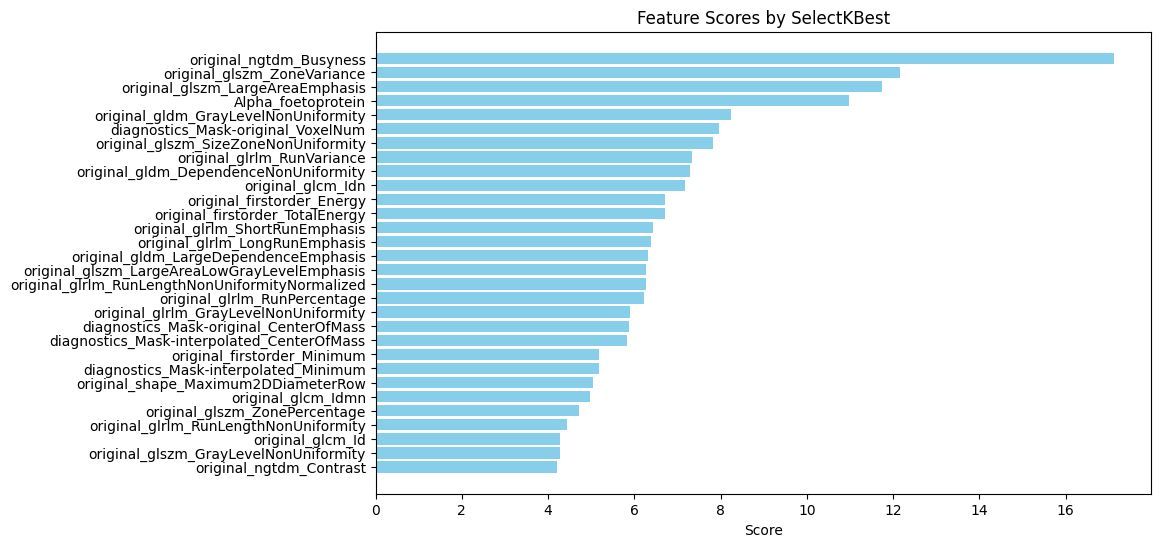

In [21]:
scores = selector.scores_[selector.get_support()]
feature_scores = pd.DataFrame({'Feature': selected_columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Feature Scores by SelectKBest')
plt.gca().invert_yaxis()
plt.show()

### Baseline Model

In [22]:
# Baseline
y_train_SMOTE.value_counts()

dead_after_one_year
0                      340
1                      340
Name: count, dtype: int64

#### Model Benchmarks 
Here, we're simply running our models with no class adjustments and no hyper-parameter tuning. It's worth noting that <b>without feature engineering, our models performed substantially worse.</b> In iterations without feature engineering our Logistic Regression and AdaBoosting classifiers completely failed to identify any true positives.

In [23]:
init_list=[]

In [24]:
lr_1y = run_model('lr',mission='After one year')

### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'model': 'lr',
 'mission': 'After one year',
 'train_auc': 0.818166089965398,
 'test_auc': 0.7303532804614274,
 'precision': 0.19718309859154928,
 'specificity': 0.6095890410958904,
 'recall': 0.7368421052631579,
 'f_score': 0.3111111111111111}

True Negatives: 89
False Positives: 57
False Negatives: 5
True Positives: 14


In [25]:
dt_1y = run_model('dt',mission='After one year')

### METRICS ###


{'model': 'dt',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.9028478731074261,
 'precision': 0.5666666666666667,
 'specificity': 0.910958904109589,
 'recall': 0.8947368421052632,
 'f_score': 0.6938775510204082}

True Negatives: 133
False Positives: 13
False Negatives: 2
True Positives: 17


In [26]:
rf_1y = run_model('rf',mission='After one year')

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


### METRICS ###


{'model': 'rf',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.9740447007930786,
 'precision': 0.8666666666666667,
 'specificity': 0.9863013698630136,
 'recall': 0.6842105263157895,
 'f_score': 0.7647058823529411}

True Negatives: 144
False Positives: 2
False Negatives: 6
True Positives: 13


In [27]:
gb_1y = run_model('gb',mission='After one year')

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### METRICS ###


{'model': 'gb',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.9686373467916366,
 'precision': 0.75,
 'specificity': 0.9657534246575342,
 'recall': 0.7894736842105263,
 'f_score': 0.7692307692307693}

True Negatives: 141
False Positives: 5
False Negatives: 4
True Positives: 15


In [28]:
et_1y = run_model('et',mission='After one year')

### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'model': 'et',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.9543979812545061,
 'precision': 0.7777777777777778,
 'specificity': 0.9726027397260274,
 'recall': 0.7368421052631579,
 'f_score': 0.7567567567567568}

True Negatives: 142
False Positives: 4
False Negatives: 5
True Positives: 14


In [29]:
svc_1y = run_model('svc',mission='After one year')

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### METRICS ###


{'model': 'svc',
 'mission': 'After one year',
 'train_auc': 0.887660034602076,
 'test_auc': 0.7606344628695025,
 'precision': 0.2361111111111111,
 'specificity': 0.6232876712328768,
 'recall': 0.8947368421052632,
 'f_score': 0.37362637362637363}

True Negatives: 91
False Positives: 55
False Negatives: 2
True Positives: 17


In [30]:
ada_1y = run_model('ada',mission='After one year')

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### METRICS ###


{'model': 'ada',
 'mission': 'After one year',
 'train_auc': 0.9982179930795848,
 'test_auc': 0.8653568853640952,
 'precision': 0.5384615384615384,
 'specificity': 0.9178082191780822,
 'recall': 0.7368421052631579,
 'f_score': 0.6222222222222222}

True Negatives: 134
False Positives: 12
False Negatives: 5
True Positives: 14


In [31]:
xg_1y = run_model('xgb',mission='After one year')

### METRICS ###


{'model': 'xgb',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.9866618601297765,
 'precision': 0.7727272727272727,
 'specificity': 0.9657534246575342,
 'recall': 0.8947368421052632,
 'f_score': 0.8292682926829268}

True Negatives: 141
False Positives: 5
False Negatives: 2
True Positives: 17


In [32]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,xgb,After one year,1.000000,0.986662,0.772727,0.965753,0.894737,0.829268
1,rf,After one year,1.000000,0.974045,0.866667,0.986301,0.684211,0.764706
2,gb,After one year,1.000000,0.968637,0.750000,0.965753,0.789474,0.769231
3,et,After one year,1.000000,0.954398,0.777778,0.972603,0.736842,0.756757
4,dt,After one year,1.000000,0.902848,0.566667,0.910959,0.894737,0.693878
5,ada,After one year,0.998218,0.865357,0.538462,0.917808,0.736842,0.622222
6,svc,After one year,0.887660,0.760634,0.236111,0.623288,0.894737,0.373626
7,lr,After one year,0.818166,0.730353,0.197183,0.609589,0.736842,0.311111


In [33]:
y1_dict = {
    lr_1y: 'LogisticRegression',
    gb_1y: 'GradientBoostingClassifier',
    ada_1y: 'AdaBoostClassifier',
    rf_1y: 'RandomForest',
    svc_1y: 'SupportVectorMachineClf',
    et_1y: 'ExtraTreeClassifier',
    dt_1y: 'DecisionTreeClassifier',
    xg_1y:'XGBClassifier'
}

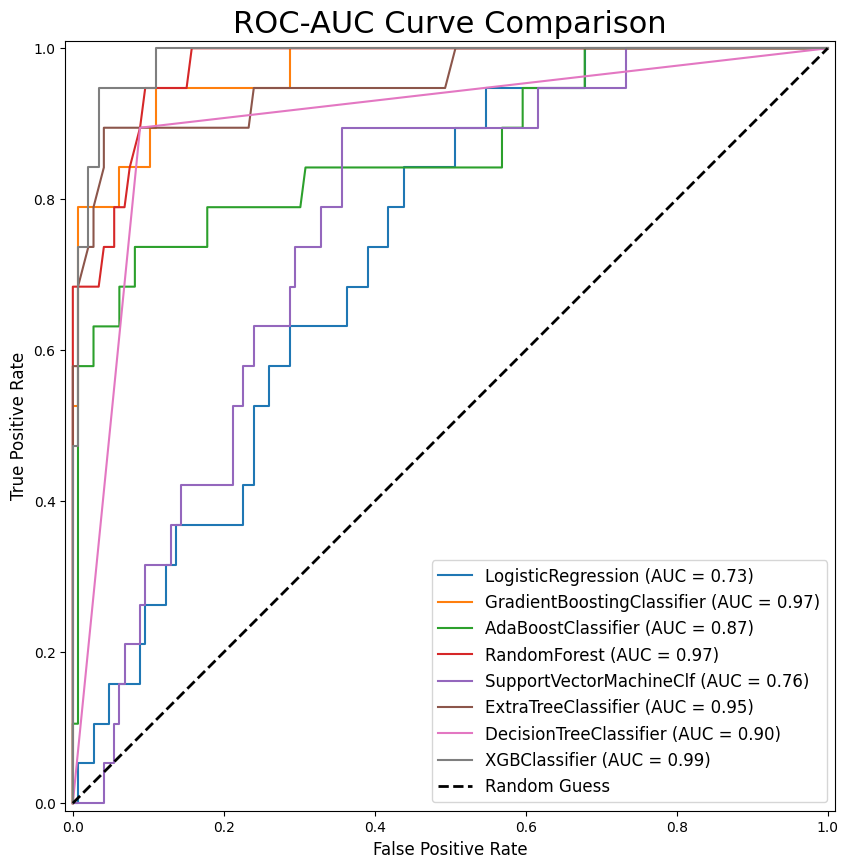

In [34]:
roc_curve_plotter(y1_dict)

### Hyperparameter selections

In [35]:
gs_list=[]

In [36]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1', 'elasticnet'],

     # Trying different alphas of: 1, 0.1, 0.05  (C = 1/alpha)
    'lr__C':[1, 10, 20],
}

In [37]:
lr_gs_1 = run_model('lr',lr_params, mission='After one year',grid_search=True)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
9 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit

### BEST PARAMS ###


{'lr__C': 1, 'lr__penalty': 'l1'}

### METRICS ###


{'model': 'lr',
 'mission': 'After one year',
 'train_auc': 0.8186418685121107,
 'test_auc': 0.7458543619322279,
 'precision': 0.1917808219178082,
 'specificity': 0.5958904109589042,
 'recall': 0.7368421052631579,
 'f_score': 0.30434782608695654}

True Negatives: 87
False Positives: 59
False Negatives: 5
True Positives: 14


In [38]:
dt_params = {'dt__max_depth': [20, 30, 40, 50],
             'dt__min_samples_split': [2, 5, 10, 15],
             'dt__min_samples_leaf': [2, 3, 4, 5],
             'dt__class_weight': ['balanced']}

In [39]:
dt_gs_1 = run_model('dt',mod_params=dt_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
### BEST PARAMS ###


{'dt__class_weight': 'balanced',
 'dt__max_depth': 20,
 'dt__min_samples_leaf': 3,
 'dt__min_samples_split': 15}

### METRICS ###


{'model': 'dt',
 'mission': 'After one year',
 'train_auc': 0.9976859861591696,
 'test_auc': 0.9001441961067052,
 'precision': 0.4838709677419355,
 'specificity': 0.8904109589041096,
 'recall': 0.7894736842105263,
 'f_score': 0.6}

True Negatives: 130
False Positives: 16
False Negatives: 4
True Positives: 15


In [40]:
ada_params = {'ada__n_estimators': [500, 1000],
              'ada__learning_rate': [0.9, 1.0],
             }

In [41]:
ada_gs_1 = run_model('ada',mod_params=ada_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### BEST PARAMS ###


{'ada__learning_rate': 0.9, 'ada__n_estimators': 1000}

### METRICS ###


{'model': 'ada',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.8940158615717375,
 'precision': 0.6,
 'specificity': 0.9452054794520548,
 'recall': 0.631578947368421,
 'f_score': 0.6153846153846154}

True Negatives: 138
False Positives: 8
False Negatives: 7
True Positives: 12


In [42]:
gb_params = {'gb__n_estimators': [500, 1000],
             'gb__learning_rate': [0.4, 0.5, 0.6],
}

In [43]:
gb_gs_1 = run_model('gb',mod_params=gb_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### BEST PARAMS ###


{'gb__learning_rate': 0.4, 'gb__n_estimators': 500}

### METRICS ###


{'model': 'gb',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.9870223503965393,
 'precision': 0.8,
 'specificity': 0.9726027397260274,
 'recall': 0.8421052631578947,
 'f_score': 0.8205128205128205}

True Negatives: 142
False Positives: 4
False Negatives: 3
True Positives: 16


In [44]:
et_params = {'et__n_estimators': [20, 25, 30, 35],
             'et__max_depth': [20, 30, 40, 50],
             'et__min_samples_leaf': [2, 3, 4],
            }

In [45]:
et_gs_1 = run_model('et',mod_params=et_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'et__max_depth': 20, 'et__min_samples_leaf': 2, 'et__n_estimators': 35}

### METRICS ###


{'model': 'et',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.9311463590483057,
 'precision': 0.7142857142857143,
 'specificity': 0.958904109589041,
 'recall': 0.7894736842105263,
 'f_score': 0.75}

True Negatives: 140
False Positives: 6
False Negatives: 4
True Positives: 15


In [46]:
svc_params = {
    'svc__C':[10, 30],
    'svc__gamma':[0.01, 0.1], 
    'svc__kernel':['rbf', 'sigmoid'],
}

In [47]:
svc_gs_1 = run_model('svc',mod_params=svc_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'svc__C': 30, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

### METRICS ###


{'model': 'svc',
 'mission': 'After one year',
 'train_auc': 0.9968425605536333,
 'test_auc': 0.9001441961067052,
 'precision': 0.625,
 'specificity': 0.9383561643835616,
 'recall': 0.7894736842105263,
 'f_score': 0.6976744186046512}

True Negatives: 137
False Positives: 9
False Negatives: 4
True Positives: 15


In [48]:
rf_params = {'rf__n_estimators': [20, 25, 30, 35],
             'rf__max_depth': [20, 30, 40, 50],
             'rf__min_samples_leaf': [2, 3, 4],
            }

In [49]:
rf_gs_1 = run_model('rf',mod_params=rf_params,mission='After one year',grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 35}

### METRICS ###


{'model': 'rf',
 'mission': 'After one year',
 'train_auc': 1.0,
 'test_auc': 0.9747656813266041,
 'precision': 0.9285714285714286,
 'specificity': 0.9931506849315068,
 'recall': 0.6842105263157895,
 'f_score': 0.7878787878787878}

True Negatives: 145
False Positives: 1
False Negatives: 6
True Positives: 13


In [50]:
pd.DataFrame(gs_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,gb,After one year,1.000000,0.987022,0.800000,0.972603,0.842105,0.820513
1,rf,After one year,1.000000,0.974766,0.928571,0.993151,0.684211,0.787879
2,et,After one year,1.000000,0.931146,0.714286,0.958904,0.789474,0.750000
3,dt,After one year,0.997686,0.900144,0.483871,0.890411,0.789474,0.600000
4,svc,After one year,0.996843,0.900144,0.625000,0.938356,0.789474,0.697674
5,ada,After one year,1.000000,0.894016,0.600000,0.945205,0.631579,0.615385
6,lr,After one year,0.818642,0.745854,0.191781,0.595890,0.736842,0.304348


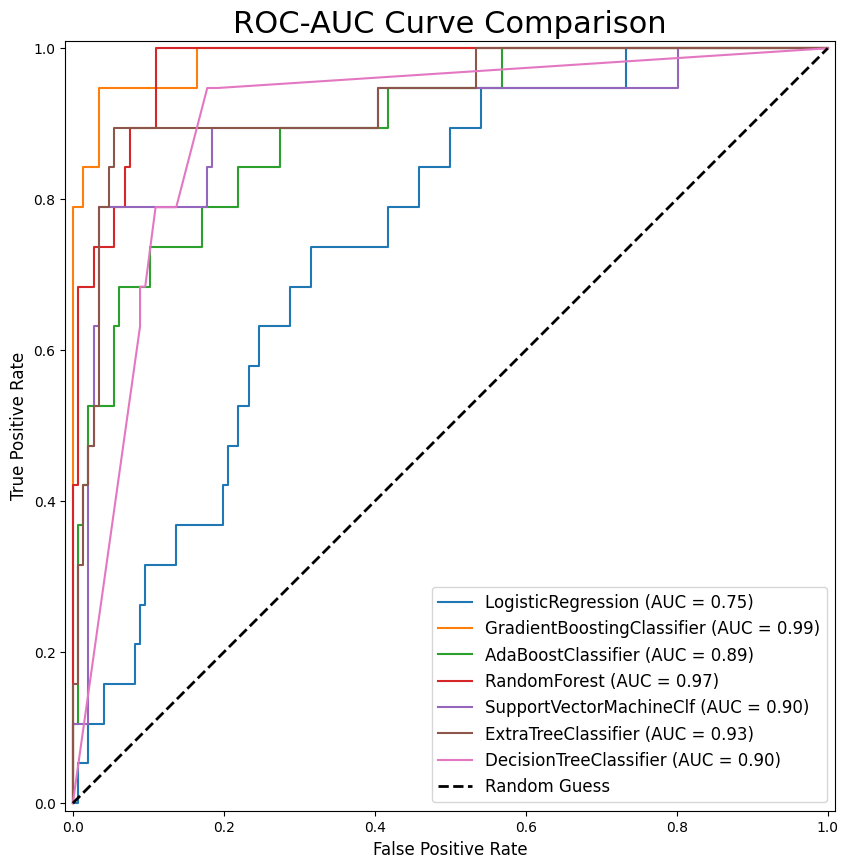

In [51]:
dict_hp_selected = {
    lr_gs_1: 'LogisticRegression',
    gb_gs_1: 'GradientBoostingClassifier',
    ada_gs_1: 'AdaBoostClassifier',
    rf_gs_1: 'RandomForest',
    svc_gs_1: 'SupportVectorMachineClf',
    et_gs_1: 'ExtraTreeClassifier',
    dt_gs_1: 'DecisionTreeClassifier',
}
roc_curve_plotter(dict_hp_selected)

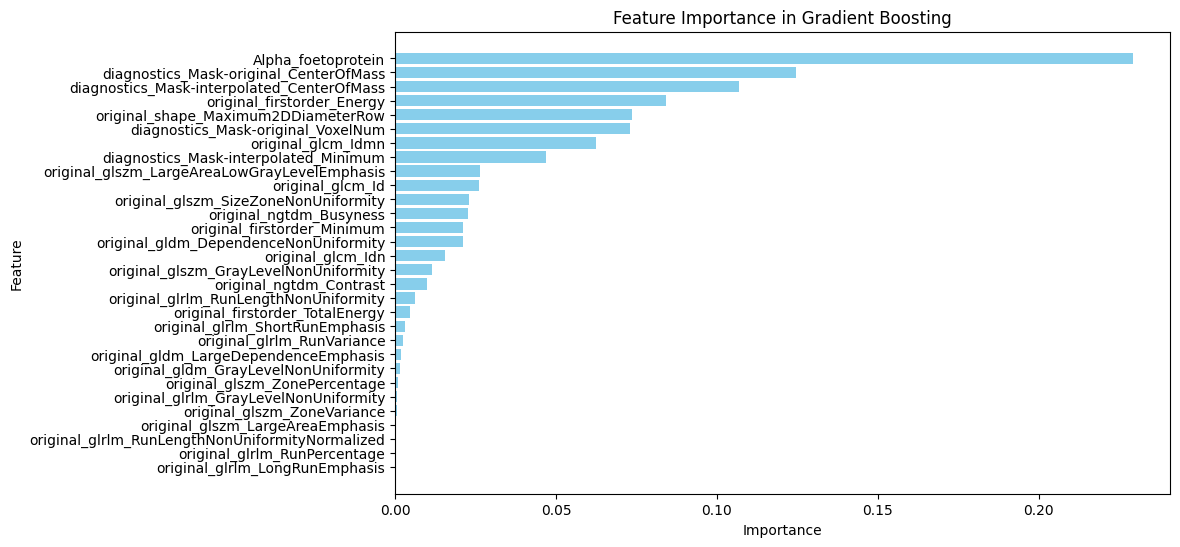

In [52]:
best_model = gb_gs_1.best_estimator_
feature_importances = best_model['gb'].feature_importances_  #feature_importances_
feature_names = X_train_selected_df.columns

feature_scores = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_scores = feature_scores.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting')
plt.gca().invert_yaxis()
plt.show()

### Six years

In [53]:
y = pd.DataFrame(data['dead_after_six_year'])
X_train, X_test, y_train, y_test = train_test_split(X_original_col, y, test_size=0.3, stratify=y, random_state=42)

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [19 32 37] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


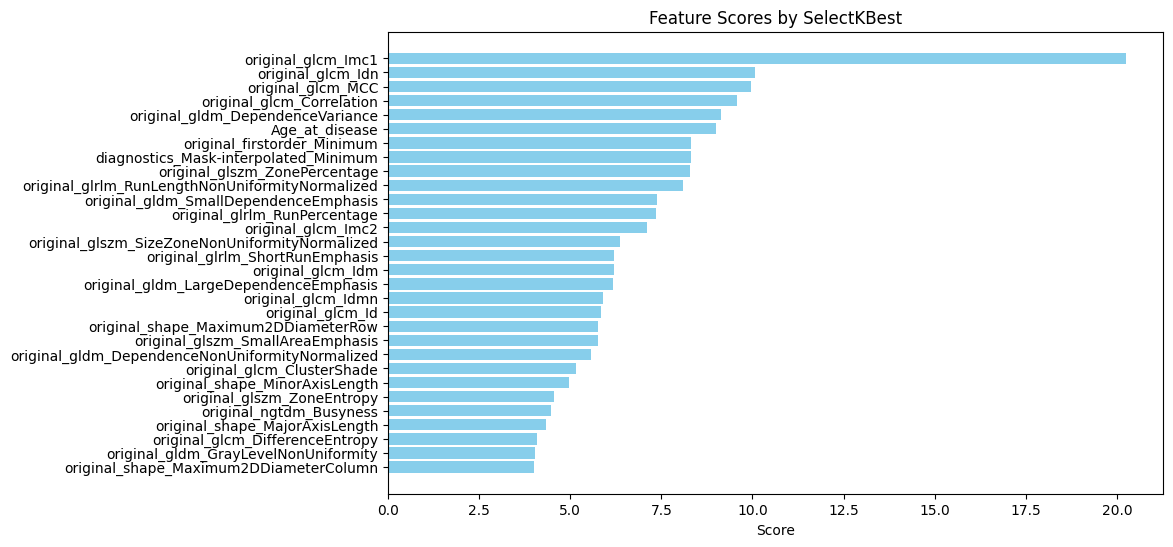

In [54]:
selector = SelectKBest(score_func=f_classif, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_columns = X_train.columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_columns,index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_columns,index=X_test.index)
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train_selected_df, y_train)

scores = selector.scores_[selector.get_support()]
feature_scores = pd.DataFrame({'Feature': selected_columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Feature Scores by SelectKBest')
plt.gca().invert_yaxis()
plt.show()

In [55]:
y_train_SMOTE.value_counts()

dead_after_six_year
0                      262
1                      262
Name: count, dtype: int64

In [56]:
init_list=[]
lr_6y = run_model('lr',mission='After six years')
dt_6y = run_model('dt',mission='After six years')
rf_6y = run_model('rf',mission='After six years')
gb_6y = run_model('gb',mission='After six years')
et_6y = run_model('et',mission='After six years')
svc_6y = run_model('svc',mission='After six years')
ada_6y = run_model('ada',mission='After six years')
xg_6y = run_model('xgb',mission='After six years')

### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'model': 'lr',
 'mission': 'After six years',
 'train_auc': 0.7393945574267233,
 'test_auc': 0.5901280323450134,
 'precision': 0.3409090909090909,
 'specificity': 0.48214285714285715,
 'recall': 0.5660377358490566,
 'f_score': 0.425531914893617}

True Negatives: 54
False Positives: 58
False Negatives: 23
True Positives: 30
### METRICS ###


{'model': 'dt',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.7458726415094339,
 'precision': 0.631578947368421,
 'specificity': 0.8125,
 'recall': 0.6792452830188679,
 'f_score': 0.6545454545454545}

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


True Negatives: 91
False Positives: 21
False Negatives: 17
True Positives: 36
### METRICS ###


{'model': 'rf',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.9070080862533693,
 'precision': 0.7547169811320755,
 'specificity': 0.8839285714285714,
 'recall': 0.7547169811320755,
 'f_score': 0.7547169811320755}

True Negatives: 99
False Positives: 13
False Negatives: 13
True Positives: 40


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### METRICS ###


{'model': 'gb',
 'mission': 'After six years',
 'train_auc': 0.9998543208437737,
 'test_auc': 0.8557951482479784,
 'precision': 0.631578947368421,
 'specificity': 0.8125,
 'recall': 0.6792452830188679,
 'f_score': 0.6545454545454545}

True Negatives: 91
False Positives: 21
False Negatives: 17
True Positives: 36
### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'model': 'et',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.9038072776280323,
 'precision': 0.782608695652174,
 'specificity': 0.9107142857142857,
 'recall': 0.6792452830188679,
 'f_score': 0.7272727272727273}

True Negatives: 102
False Positives: 10
False Negatives: 17
True Positives: 36


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### METRICS ###


{'model': 'svc',
 'mission': 'After six years',
 'train_auc': 0.8314637841617621,
 'test_auc': 0.6603773584905661,
 'precision': 0.40425531914893614,
 'specificity': 0.5,
 'recall': 0.7169811320754716,
 'f_score': 0.5170068027210885}

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


True Negatives: 56
False Positives: 56
False Negatives: 15
True Positives: 38
### METRICS ###


{'model': 'ada',
 'mission': 'After six years',
 'train_auc': 0.9773250393333721,
 'test_auc': 0.7566543126684635,
 'precision': 0.5846153846153846,
 'specificity': 0.7589285714285714,
 'recall': 0.7169811320754716,
 'f_score': 0.6440677966101694}

True Negatives: 85
False Positives: 27
False Negatives: 15
True Positives: 38
### METRICS ###


{'model': 'xgb',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.9435646900269542,
 'precision': 0.7666666666666667,
 'specificity': 0.875,
 'recall': 0.8679245283018868,
 'f_score': 0.8141592920353983}

True Negatives: 98
False Positives: 14
False Negatives: 7
True Positives: 46


In [57]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,xgb,After six years,1.000000,0.943565,0.766667,0.875000,0.867925,0.814159
1,rf,After six years,1.000000,0.907008,0.754717,0.883929,0.754717,0.754717
2,et,After six years,1.000000,0.903807,0.782609,0.910714,0.679245,0.727273
3,gb,After six years,0.999854,0.855795,0.631579,0.812500,0.679245,0.654545
4,ada,After six years,0.977325,0.756654,0.584615,0.758929,0.716981,0.644068
5,dt,After six years,1.000000,0.745873,0.631579,0.812500,0.679245,0.654545
6,svc,After six years,0.831464,0.660377,0.404255,0.500000,0.716981,0.517007
7,lr,After six years,0.739395,0.590128,0.340909,0.482143,0.566038,0.425532


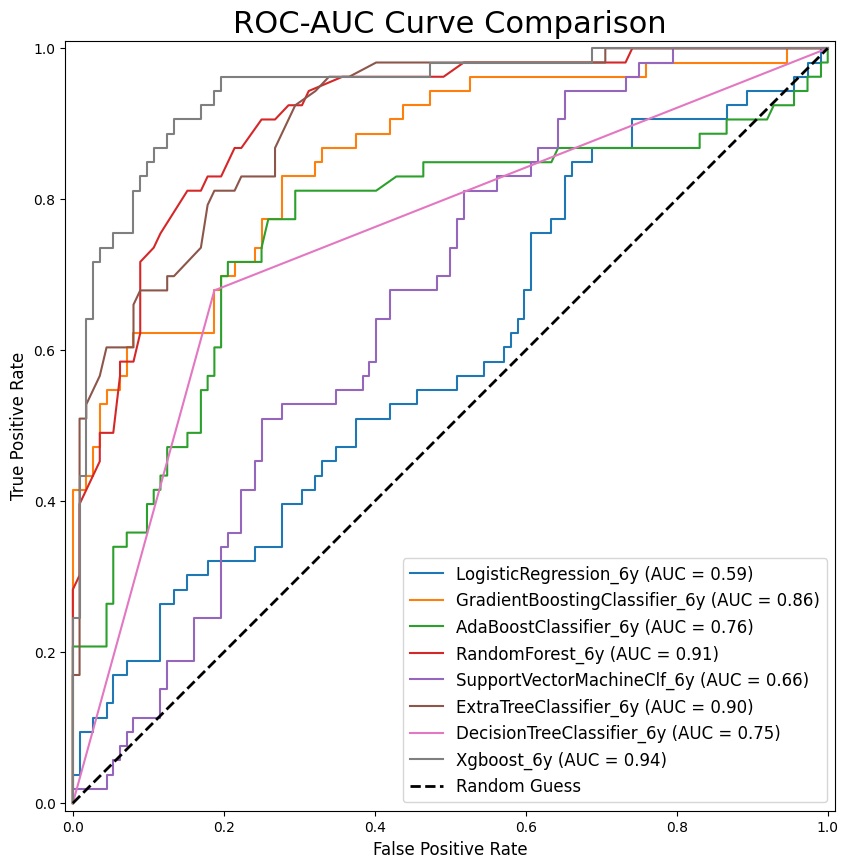

In [58]:
y6_dict = {
    lr_6y: 'LogisticRegression_6y',
    gb_6y: 'GradientBoostingClassifier_6y',
    ada_6y: 'AdaBoostClassifier_6y',
    rf_6y: 'RandomForest_6y',
    svc_6y: 'SupportVectorMachineClf_6y',
    et_6y: 'ExtraTreeClassifier_6y',
    dt_6y: 'DecisionTreeClassifier_6y',
    xg_6y:'Xgboost_6y'
}
roc_curve_plotter(y6_dict)

#### Hyperparameter selections

In [59]:
gs_list=[]

In [60]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1', 'elasticnet'],

     # Trying different alphas of: 1, 0.1, 0.05  (C = 1/alpha)
    'lr__C':[1, 10, 20],
}

In [61]:
lr_gs = run_model('lr',lr_params, mission='After six years',grid_search=True)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
9 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit

{'lr__C': 1, 'lr__penalty': 'l1'}

### METRICS ###


{'model': 'lr',
 'mission': 'After six years',
 'train_auc': 0.7270555328943534,
 'test_auc': 0.5724393530997305,
 'precision': 0.3409090909090909,
 'specificity': 0.48214285714285715,
 'recall': 0.5660377358490566,
 'f_score': 0.425531914893617}

True Negatives: 54
False Positives: 58
False Negatives: 23
True Positives: 30


In [62]:
dt_params = {'dt__max_depth': [20, 30, 40, 50],
             'dt__min_samples_split': [1, 5, 10, 15],
             'dt__min_samples_leaf': [2, 3, 4, 5],
             'dt__class_weight': ['balanced']}

In [63]:
dt_gs = run_model('dt',mod_params=dt_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
48 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.

{'dt__class_weight': 'balanced',
 'dt__max_depth': 20,
 'dt__min_samples_leaf': 3,
 'dt__min_samples_split': 5}

### METRICS ###


{'model': 'dt',
 'mission': 'After six years',
 'train_auc': 0.9945953033040031,
 'test_auc': 0.7536219676549866,
 'precision': 0.6140350877192983,
 'specificity': 0.8035714285714286,
 'recall': 0.660377358490566,
 'f_score': 0.6363636363636364}

True Negatives: 90
False Positives: 22
False Negatives: 18
True Positives: 35


In [64]:
ada_params = {'ada__n_estimators': [500, 1000],
              'ada__learning_rate': [0.9, 1.0],
             }

In [65]:
ada_gs = run_model('ada',mod_params=ada_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### BEST PARAMS ###


{'ada__learning_rate': 0.9, 'ada__n_estimators': 1000}

### METRICS ###


{'model': 'ada',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.7966644204851752,
 'precision': 0.639344262295082,
 'specificity': 0.8035714285714286,
 'recall': 0.7358490566037735,
 'f_score': 0.6842105263157895}

True Negatives: 90
False Positives: 22
False Negatives: 14
True Positives: 39


In [66]:
gb_params = {'gb__n_estimators': [500, 1000],
             'gb__learning_rate': [0.4, 0.5, 0.6],
}

In [67]:
gb_gs = run_model('gb',mod_params=gb_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### BEST PARAMS ###


{'gb__learning_rate': 0.4, 'gb__n_estimators': 500}

### METRICS ###


{'model': 'gb',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.9545148247978437,
 'precision': 0.7580645161290323,
 'specificity': 0.8660714285714286,
 'recall': 0.8867924528301887,
 'f_score': 0.8173913043478261}

True Negatives: 97
False Positives: 15
False Negatives: 6
True Positives: 47


In [68]:
et_params = {'et__n_estimators': [20, 25, 30, 35],
             'et__max_depth': [20, 30, 40, 50],
             'et__min_samples_leaf': [2, 3, 4],
            }

In [69]:
et_gs = run_model('et',mod_params=et_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'et__max_depth': 20, 'et__min_samples_leaf': 2, 'et__n_estimators': 30}

### METRICS ###


{'model': 'et',
 'mission': 'After six years',
 'train_auc': 1.0,
 'test_auc': 0.8746630727762804,
 'precision': 0.6428571428571429,
 'specificity': 0.8214285714285714,
 'recall': 0.6792452830188679,
 'f_score': 0.6605504587155964}

True Negatives: 92
False Positives: 20
False Negatives: 17
True Positives: 36


In [70]:
svc_params = {
    'svc__C':[10, 30],
    'svc__gamma':[0.01, 0.1], 
    'svc__kernel':['rbf', 'sigmoid'],
}

In [71]:
svc_gs = run_model('svc',mod_params=svc_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'svc__C': 30, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

### METRICS ###


{'model': 'svc',
 'mission': 'After six years',
 'train_auc': 0.9999854320843774,
 'test_auc': 0.8370956873315363,
 'precision': 0.6290322580645161,
 'specificity': 0.7946428571428571,
 'recall': 0.7358490566037735,
 'f_score': 0.6782608695652174}

True Negatives: 89
False Positives: 23
False Negatives: 14
True Positives: 39


In [72]:
rf_params = {'rf__n_estimators': [20, 25, 30, 35],
             'rf__max_depth': [20, 30, 40, 50],
             'rf__min_samples_leaf': [2, 3, 4],
            }

In [73]:
rf_gs = run_model('rf',mod_params=rf_params,mission='After six years',grid_search=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 25}

### METRICS ###


{'model': 'rf',
 'mission': 'After six years',
 'train_auc': 0.9999854320843774,
 'test_auc': 0.8877190026954178,
 'precision': 0.7358490566037735,
 'specificity': 0.875,
 'recall': 0.7358490566037735,
 'f_score': 0.7358490566037735}

True Negatives: 98
False Positives: 14
False Negatives: 14
True Positives: 39


In [74]:
pd.DataFrame(gs_list).sort_values(by=['test_auc','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_auc,test_auc,precision,specificity,recall,f_score
0,gb,After six years,1.000000,0.954515,0.758065,0.866071,0.886792,0.817391
1,rf,After six years,0.999985,0.887719,0.735849,0.875000,0.735849,0.735849
2,et,After six years,1.000000,0.874663,0.642857,0.821429,0.679245,0.660550
3,svc,After six years,0.999985,0.837096,0.629032,0.794643,0.735849,0.678261
4,ada,After six years,1.000000,0.796664,0.639344,0.803571,0.735849,0.684211
5,dt,After six years,0.994595,0.753622,0.614035,0.803571,0.660377,0.636364
6,lr,After six years,0.727056,0.572439,0.340909,0.482143,0.566038,0.425532


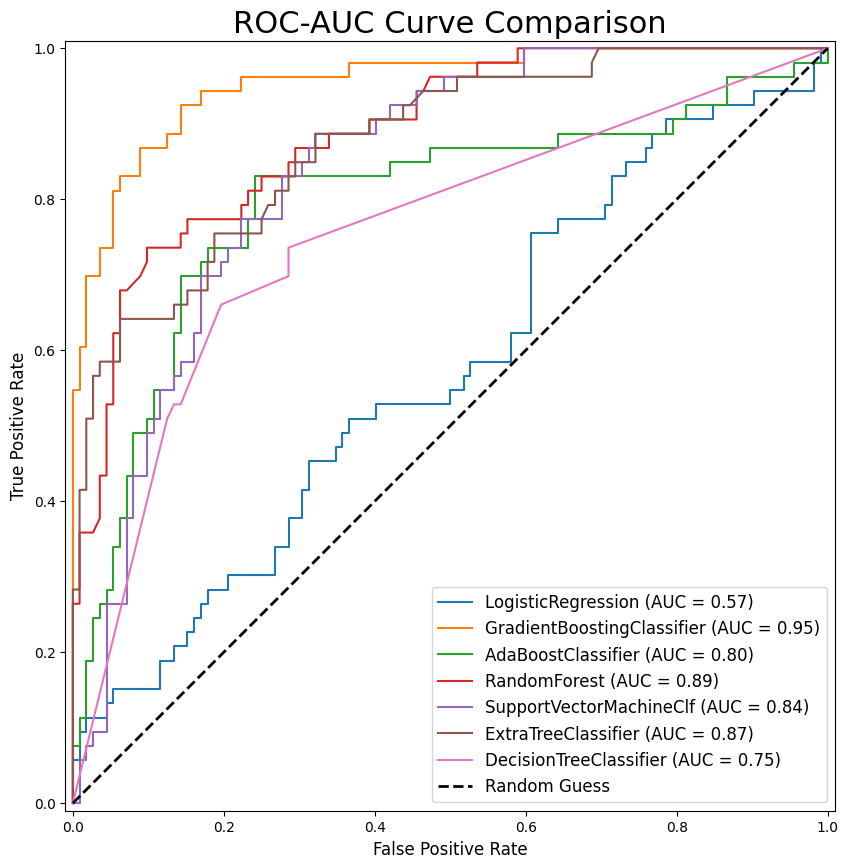

In [75]:
dict_hp_selected = {
    lr_gs: 'LogisticRegression',
    gb_gs: 'GradientBoostingClassifier',
    ada_gs: 'AdaBoostClassifier',
    rf_gs: 'RandomForest',
    svc_gs: 'SupportVectorMachineClf',
    et_gs: 'ExtraTreeClassifier',
    dt_gs: 'DecisionTreeClassifier',
}
roc_curve_plotter(dict_hp_selected)

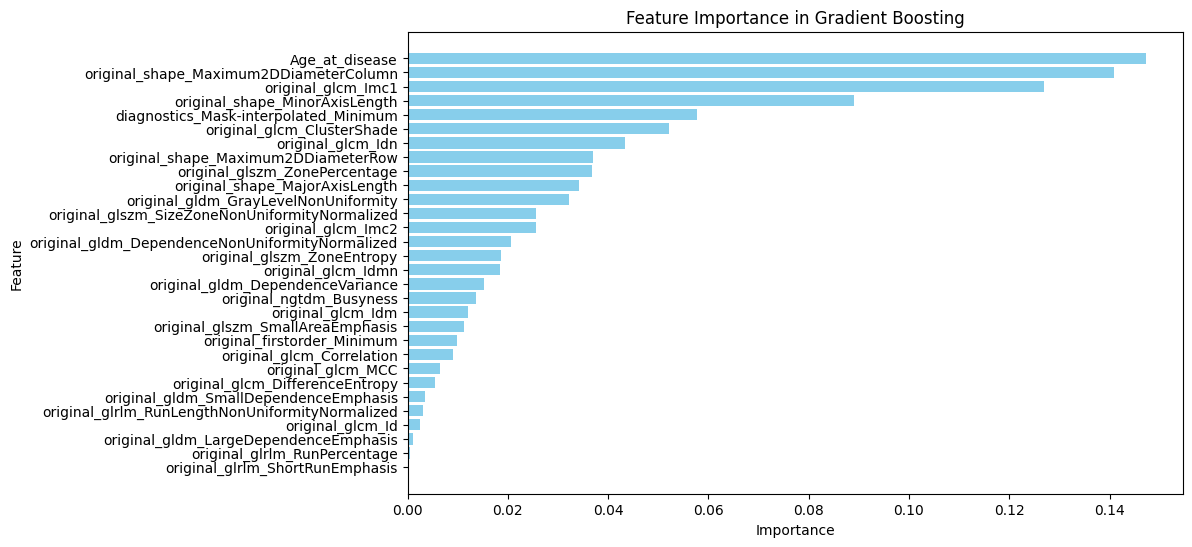

In [77]:
best_model = gb_gs.best_estimator_
feature_importances = best_model['gb'].feature_importances_   #feature_importances_
feature_names = X_train_selected_df.columns

feature_scores = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_scores = feature_scores.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting')
plt.gca().invert_yaxis()
plt.show()
